In [17]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression

import warnings
import numpy as np
from collections import OrderedDict

from lob_data_utils import lob, db_result, overview
from lob_data_utils.svm_calculation import lob_svm

sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data_length = 10000
stock = '11869'

In [3]:
df, df_cv, df_test = lob.load_prepared_data(
    stock, data_dir='../queue_imbalance/data/prepared', cv=True, length=data_length)

## Logistic

0.5726926523297491

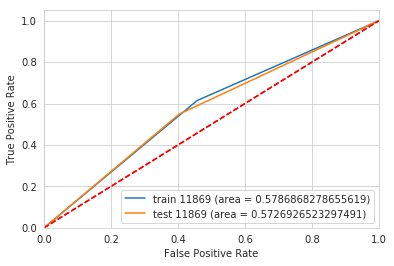

In [4]:
log_clf = lob.logistic_regression(df, 0, len(df))
pred_train = log_clf.predict(df['queue_imbalance'].values.reshape(-1, 1))
pred_test = log_clf.predict(df_test['queue_imbalance'].values.reshape(-1, 1))
df['pred_log'] = pred_train
df_test['pred_log'] = pred_test
lob.plot_roc(df, log_clf, stock=int(stock), label='train')
lob.plot_roc(df_test, log_clf, stock=int(stock), label='test')

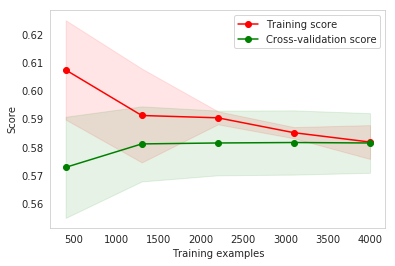

In [5]:
lob.plot_learning_curve(log_clf, df['queue_imbalance'].values.reshape(-1, 1), df['mid_price_indicator'])

### Let's look inside

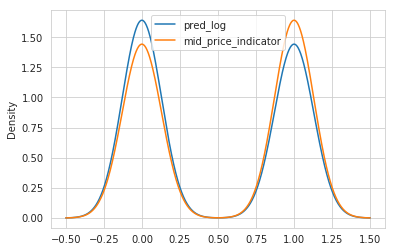

In [6]:
df_test[df_test['pred_log'] != df_test['mid_price_indicator']][['pred_log', 'mid_price_indicator']].plot(kind='kde')

In [7]:
print(len(df_test[df_test['pred_log'] != df_test['mid_price_indicator']]), len(df_test))
df_test[df_test['pred_log'] != df_test['mid_price_indicator']][['pred_log', 'mid_price_indicator', 'queue_imbalance']].head()

855 2000


,pred_log,mid_price_indicator,queue_imbalance
3,0.0,1.0,-0.201413
5,1.0,0.0,0.039879
10,1.0,0.0,0.681627
15,1.0,0.0,0.360843
16,1.0,0.0,0.664000


In [8]:
pivot = min(df[df['pred_log'] == 1]['queue_imbalance'])
pivot

-0.03734439834024896

In [9]:
print('Amount of positive samples below the pivot and negative above the pivot for training data:')
print(len(df[df['queue_imbalance'] < pivot][df['pred_log'] == 1]), 
      len(df[df['queue_imbalance'] >= pivot][df['pred_log'] == 0]))

print('Amount of positive samples below the pivot and negative above the pivot for testing data:')
print(len(df_test[df_test['queue_imbalance'] < pivot][df_test['pred_log'] == 1]), 
      len(df_test[df_test['queue_imbalance'] >= pivot][df_test['pred_log'] == 0]))

Amount of positive samples below the pivot and negative above the pivot for training data:
0 0
Amount of positive samples below the pivot and negative above the pivot for testing data:
0 0


So this classifier just finds a pivot. But why this particular one is choosen? Let's check what amount of data is below and above the pivot.

In [10]:
len(df[df['queue_imbalance'] < pivot]), len(df[df['queue_imbalance'] >= pivot])

(2776, 3224)

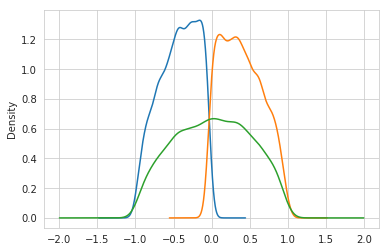

In [11]:
df[df['queue_imbalance'] < pivot]['queue_imbalance'].plot(kind='kde')
df[df['queue_imbalance'] >= pivot]['queue_imbalance'].plot(kind='kde')
df['queue_imbalance'].plot(kind='kde')

## SVM

In [18]:
overview_data = overview.Overview(stock, data_length)

gammas = [0.0005, 0.005, 1, 5, 50, 500, 5000]
cs = [0.0005, 0.005, 1, 5.0, 50, 500, 1000]
coef0s = [0, 0.0005, 0.005, 1, 5, 50, 500, 5000]

df_svm_res = overview_data.write_svm_results(df, df_cv, gammas=gammas, cs=cs, coef0s=coef0s)
unnamed_columns = [c for c in df_svm_res.columns if 'Unnamed' in c]
df_svm_res.drop(columns=unnamed_columns, inplace=True)
df_svm_res.sort_values(by='roc_cv_score', ascending=False).head()

Results read from file


,svm,c,gamma,coef0,roc_cv_score,roc_train_score
0,sigmoid,0.005,500.000,5.0,0.565739,0.578554
1,rbf,0.005,50.000,NaN,0.565326,0.569674
2,sigmoid,0.005,5000.000,50.0,0.565183,0.580281
3,rbf,5.000,50.000,NaN,0.564847,0.581670
4,sigmoid,500.000,0.005,1.0,0.564812,0.578852


In [13]:
df_svm_res.head()

,svm,c,gamma,coef0,roc_cv_score,roc_train_score
0,sigmoid,0.005,500.000,5.0,0.565739,0.578554
1,rbf,0.005,50.000,NaN,0.565326,0.569674
2,sigmoid,0.005,5000.000,50.0,0.565183,0.580281
3,rbf,5.000,50.000,NaN,0.564847,0.581670
4,sigmoid,500.000,0.005,1.0,0.564812,0.578852


In [14]:
df_svm_res.sort_values(by='roc_cv_score', ascending=False).head()

,svm,c,gamma,coef0,roc_cv_score,roc_train_score
447,sigmoid,5.0,5000.0,0.0050,0.487149,0.462868
446,sigmoid,5.0,5000.0,0.0005,0.487149,0.463717
445,sigmoid,5.0,5000.0,0.0000,0.487631,0.463553
444,sigmoid,1.0,5000.0,1.0000,0.490782,0.459714
443,sigmoid,50.0,50.0,50.0000,0.495439,0.498900


## GDF

In [20]:
K = 50

rr = [0.01, 0.05, 0.1, 0.5, 1.0]
ss = [0.01, 0.05, 0.1, 0.5, 1.0]

Kn = 10

df_gdf_res = overview_data.write_svm_gdf(K=K, Kn=Kn, rr=rr, ss=ss)
df_gdf_res.sort_values(by='roc_cv_score', ascending=False).head()

Results read from file


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,K,Kn,c,gamma,r,roc_cv_score,roc_train_score,s,stock,svm
1,1,1,1.0,50,10,1,10,0.01,0.74087,0.544520,0.01,11869,rbf
431,431,431,NaN,50,10,10,10,0.05,0.74087,0.543500,0.10,11869,rbf
357,357,357,NaN,50,10,10,100,0.01,0.74087,0.504420,1.00,11869,rbf
91,91,91,91.0,50,10,1000,10,0.01,0.74087,0.504420,0.50,11869,rbf
551,551,551,NaN,50,10,1,10,1.00,0.74087,0.519718,0.10,11869,rbf


In [ ]:
len(df_gdf_res)

## GDF with logistic reg

In [43]:
K = 50
length = data_length
rr = [0.01, 0.05, 0.1, 0.5, 1.0]
ss = [0.01, 0.05, 0.1, 0.5, 1.0]
Cs = [1, 10, 100, 1000, 10000]
Kn = 10

df_gdf_log_res = overview_data.write_gdf_logistic(K=K, Kn=Kn, rr=rr, ss=ss, Cs=Cs)
df_gdf_log_res.sort_values(by=['roc_cv_score', 'roc_train_score'], ascending=False).head()

Results read from file


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,c,roc_cv_score,roc_train_score,K,Kn,r,s,stock
19,19,19,19,19,19,10000,0.740870,0.548672,50,10,0.01,0.5,11869
21,21,21,21,21,21,10,0.740870,0.454379,50,10,0.01,1.0,11869
86,86,86,86,86,86,10,0.617156,0.517427,50,10,0.50,0.1,11869
60,60,60,60,60,60,1,0.610218,0.510433,50,10,0.10,0.1,11869
110,110,110,110,110,110,1,0.610218,0.510426,50,10,1.00,0.1,11869


### Can we use logisitic regression to find gdf params and then use SVM?

It does not seem so unfortunatelly.

In [35]:
def compare(df_gdf_res, df_gdf_log_res):
    res_best = df_gdf_res.sort_values(by='roc_cv_score', ascending=False)
    df_gdf_log_res = df_gdf_log_res.sort_values(by='roc_cv_score', ascending=False)
    comp = []
    for i, row in res_best.iterrows():
        r = df_gdf_log_res[df_gdf_log_res['r'] == row['r']][df_gdf_log_res['s'] == row['s']].iloc[0]
        comp.append({
            'roc_cv_score': row['roc_cv_score'],
            'roc_train_score': row['roc_train_score'],
            'r': row['r'],
            's': row['s'],
            'roc_cv_score_log': r['roc_cv_score'],
            'roc_train_score_log': r['roc_train_score']
        })
    return pd.DataFrame(comp).sort_values(
        by=['roc_cv_score', 'roc_cv_score_log'], ascending=False).dropna()
compare(df_gdf_res, df_gdf_log_res)

,r,roc_cv_score,roc_cv_score_log,roc_train_score,roc_train_score_log,s
2,0.01,0.740870,0.740870,0.504420,0.454379,1.00
3,0.01,0.740870,0.740870,0.504420,0.548672,0.50
4,1.00,0.740870,0.610218,0.519718,0.510426,0.10
1,0.05,0.740870,0.587472,0.543500,0.513190,0.10
6,0.05,0.740870,0.587472,0.536987,0.513190,0.10
0,0.01,0.740870,0.500972,0.544520,0.531127,0.01
5,0.01,0.740870,0.500972,0.544429,0.531127,0.01
7,0.01,0.641103,0.740870,0.554462,0.548672,0.50
8,0.50,0.641103,0.510300,0.529393,0.524650,0.50
9,0.50,0.630225,0.617156,0.522207,0.517427,0.10


## Results on test

In [45]:
best_gdf_res = df_gdf_res.sort_values(by=['roc_cv_score', 'roc_train_score'], ascending=False).iloc[0]

best_gdf_log_res = df_gdf_log_res.sort_values(by=['roc_cv_score', 'roc_train_score'], ascending=False).iloc[0]
best_gdf_res_svm_on_log = df_gdf_res[df_gdf_res['r'] == best_gdf_log_res['r']][df_gdf_res[
    's'] == best_gdf_log_res['s']].sort_values(by=['roc_cv_score', 'roc_train_score'], ascending=False).iloc[0]
best_svm_sig_res = df_svm_res[df_svm_res['svm'] == 'sigmoid'].sort_values(
    by='roc_cv_score', ascending=False).iloc[0]
best_svm_rbf_res = df_svm_res[df_svm_res['svm'] == 'rbf'].sort_values(
    by='roc_cv_score', ascending=False).iloc[0]          
best_svm_lin_res = df_svm_res[df_svm_res['svm'] == 'linear'].sort_values(
    by='roc_cv_score', ascending=False).iloc[0]
res_dict = OrderedDict({
    'gdf_svm': best_gdf_res,
    'gdf_svm_on_log': best_gdf_res_svm_on_log,
    'gdf_log': best_gdf_log_res,
    'svm_rbf': best_svm_rbf_res,
    'svm_lin': best_svm_lin_res,
    'svm_sig': best_svm_sig_res,
})

In [46]:
list(res_dict.values())[0]

Unnamed: 0               1
Unnamed: 0.1             1
Unnamed: 0.1.1           1
K                       50
Kn                      10
c                        1
gamma                   10
r                     0.01
roc_cv_score       0.74087
roc_train_score    0.54452
s                     0.01
stock                11869
svm                    rbf
Name: 1, dtype: object

In [47]:
def gdf_svm_classification(df, K, C=1000, gamma=1):
    gdf_columns = ['gdf_' + str(i) for i in range(0, K)]
    clf = SVC(kernel='rbf', C=C, gamma=gamma)
    X = df.loc[:, gdf_columns]
    y = df['mid_price_indicator'].values.reshape(-1, 1)
    y[0] = 0
    clf.fit(X, y)
    return clf

filename = 'gdf_{}_len{}_r{}_s{}_K{}'.format(stock, length, best_gdf_res['r'], best_gdf_res['s'], 
                                             int(best_gdf_res['K']))
dfs, dfs_cv, dfs_test = lob.load_prepared_data(
    filename, data_dir='../gaussian_filter/data_gdf/', cv=True, length=length)
svm_gdf_clf = gdf_svm_classification(dfs, K, C=best_gdf_res['c'], gamma=best_gdf_res['gamma'])
gdf_columns = ['gdf_' + str(i) for i in range(0, K)]
pred_test = svm_gdf_clf.predict(dfs_test.loc[:, gdf_columns])
roc_test = roc_auc_score(pred_test, dfs_test['mid_price_indicator'])
best_gdf_res['roc_test_score'] = roc_test
roc_test

0.49543447245057415

In [52]:
def gdf_log_classification(df, K, C=1000):
    gdf_columns = ['gdf_' + str(i) for i in range(0, K)]
    clf = LogisticRegression(C=C)
    X = df.loc[:, gdf_columns]
    y = df['mid_price_indicator'].values.reshape(-1, 1)
    y[0] = 0
    clf.fit(X, y)
    return clf

filename = 'gdf_{}_len{}_r{}_s{}_K{}'.format(
    stock, length, best_gdf_log_res['r'], best_gdf_log_res['s'], int(best_gdf_log_res['K']))
dfs, dfs_cv, dfs_test = lob.load_prepared_data(
    filename, data_dir='../gaussian_filter/data_gdf/', cv=True, length=length)
svm_gdf_clf = gdf_log_classification(dfs, K, C=best_gdf_log_res['c'])
gdf_columns = ['gdf_' + str(i) for i in range(0, K)]
pred_test = svm_gdf_clf.predict(dfs_test.loc[:, gdf_columns])
roc_test = roc_auc_score(pred_test, dfs_test['mid_price_indicator'])
best_gdf_log_res['roc_test_score'] = roc_test
roc_test

0.5439456704576837

In [49]:
df, df_cv, df_test = lob.load_prepared_data(
    stock, data_dir='../queue_imbalance/data/prepared', cv=True, length=data_length)

svm = lob_svm.SVMRbf(stock, df, c=best_svm_rbf_res['c'], gamma=best_svm_rbf_res['gamma'], data_length=data_length)
roc_test = svm.predict(df_test, 'test', check=False)
best_svm_rbf_res['roc_test_score'] = roc_test

svm = lob_svm.SVMSigmoid(stock, df, c=best_svm_sig_res['c'], 
                         gamma=best_svm_sig_res['gamma'], coef0=best_svm_sig_res['coef0'])
roc_test = svm.predict(df_test, 'test', check=False)
best_svm_sig_res['roc_test_score'] = roc_test

svm = lob_svm.SVMLinear(stock, df, c=best_svm_lin_res['c'])
roc_test = svm.predict(df_test, 'test', check=False)
best_svm_lin_res['roc_test_score'] = roc_test

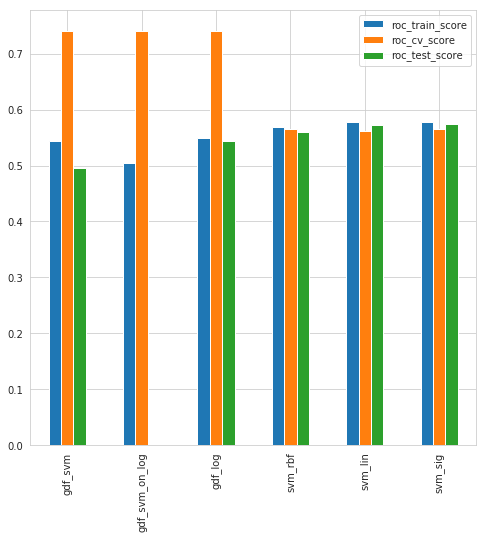

In [53]:
res = []
for k, v in res_dict.items():
    dd = v.to_dict()
    dd['type'] = k
    res.append(dd)
df_res = pd.DataFrame(res)

df_res[['roc_train_score', 'roc_cv_score', 'roc_test_score']].plot(kind='bar', figsize=(8, 8))
d = plt.xticks(list(range(len(res_dict.keys()))), list(res_dict.keys()))
plt.legend(loc='upper right')